In [ ]:
import numpy as np
import pandas as pd
import datetime
from astropy.time import Time
from astropy.table import vstack, Table, MaskedColumn
from astroquery.eso import Eso
from astral import Observer
from astral.sun import time_at_elevation

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

ISO 8601 compliant date-time format “YYYY-MM-DDTHH:MM:SS.sss…”. This is the same as TimeISO except for a “T” instead of space between the date and time. For example, 2000-01-01T00:00:00.000 is midnight on January 1, 2000.

In [ ]:
# Define Observatory Location (Replace with actual latitude & longitude)
latitude = -24.6275  # Example: Paranal Observatory, Chile - DOUBLE CHECK
longitude = -70.4042
elevation = 2635  # Meters
observer = Observer(latitude, longitude, elevation)

# Define time range for 2024
dates = [datetime.date(2024, 1, 1) + datetime.timedelta(days=i) for i in range(366)]
# dates = [datetime.date(2024, 1, 1) + datetime.timedelta(days=i) for i in range(250, 300)]

# Compute LST when Sun is -35 degrees below the horizon
lst_times = []
for date in dates:
    sun_time = time_at_elevation(observer, -35, date, direction='rising')
    lst_times.append(sun_time)

# Convert to MJD for TAP query
times = [Time(t).isot for t in lst_times]
times_mjd = Time(times).mjd

# Build queries for each day
query_template = (
    "SELECT TOP 50 * \n"
    "FROM dbo.raw \n"
    "WHERE instrument = 'ALPACA' \n"
    "AND date_obs BETWEEN '{start_time}' AND '{end_time}' \n"
    "ORDER BY date_obs ASC \n"
)

eso = Eso()
eso.ROW_LIMIT = 200
results = []
columns = None  # To store column names for masked rows

for i, date in enumerate(dates):
    start_time = (Time(times[i]) - 0.02).isot  # Start time slightly before
    end_time = (Time(times[i]) + 0.02).isot  # End time slightly after
    query = query_template.format(start_time=start_time, end_time=end_time)
    
    print(f"Querying for: {date} at LST {times[i]}")
    result = eso.query_tap_service(query) # Results output as astropy.table
    
    if result:
        # Store column names for masked rows
        if columns is None:
            columns = result.colnames
        
        # Convert date_obs column to Time format for comparison
        result_times = Time(list(result['date_obs'].data.data))
        target_time = Time(times[i])
        
        # Find the closest observation
        closest_index = np.argmin(np.abs(result_times - target_time))
        closest_result = result[closest_index]

        print(f"Closest observations found: {closest_result['date_obs']}")
        results.append(closest_result)
    else: 
        # Create a masked row with the same columns
        print(f"No observations found: {closest_result['date_obs']}")
        continue

# Stack results as astropy.table
if results:
    results = vstack(results, join_type='outer')

Querying for: 2024-01-01 at LST 2024-01-01T06:23:34.143
Closest observations found: 2024-01-01T06:23:08.420
Querying for: 2024-01-02 at LST 2024-01-02T06:24:42.415
Closest observations found: 2024-01-02T06:25:29.060
Querying for: 2024-01-03 at LST 2024-01-03T06:25:53.659
Closest observations found: 2024-01-03T06:25:32.120
Querying for: 2024-01-04 at LST 2024-01-04T06:27:07.731
Closest observations found: 2024-01-04T06:28:10.470
Querying for: 2024-01-05 at LST 2024-01-05T06:28:24.481
Closest observations found: 2024-01-05T06:28:10.700
Querying for: 2024-01-06 at LST 2024-01-06T06:29:43.756
Closest observations found: 2024-01-06T06:30:10.420
Querying for: 2024-01-07 at LST 2024-01-07T06:31:05.400
Closest observations found: 2024-01-07T06:30:32.020
Querying for: 2024-01-08 at LST 2024-01-08T06:32:29.258
Closest observations found: 2024-01-08T06:33:12.750
Querying for: 2024-01-09 at LST 2024-01-09T06:33:55.171
Closest observations found: 2024-01-09T06:34:40.000
Querying for: 2024-01-10 at 

No observations found: 2024-01-14T06:41:45.070
Querying for: 2024-01-16 at LST 2024-01-16T06:44:41.054
Closest observations found: 2024-01-16T06:45:11.160
Querying for: 2024-01-17 at LST 2024-01-17T06:46:17.880
Closest observations found: 2024-01-17T06:46:41.570
Querying for: 2024-01-18 at LST 2024-01-18T06:47:55.419
Closest observations found: 2024-01-18T06:48:46.510
Querying for: 2024-01-19 at LST 2024-01-19T06:49:33.540
Closest observations found: 2024-01-19T06:50:11.730
Querying for: 2024-01-20 at LST 2024-01-20T06:51:12.115
Closest observations found: 2024-01-20T06:50:20.720
Querying for: 2024-01-21 at LST 2024-01-21T06:52:51.022
Closest observations found: 2024-01-21T06:51:53.640
Querying for: 2024-01-22 at LST 2024-01-22T06:54:30.144
Closest observations found: 2024-01-22T06:54:34.840
Querying for: 2024-01-23 at LST 2024-01-23T06:56:09.367
Closest observations found: 2024-01-23T06:55:48.980
Querying for: 2024-01-24 at LST 2024-01-24T06:57:48.584
Closest observations found: 2024-

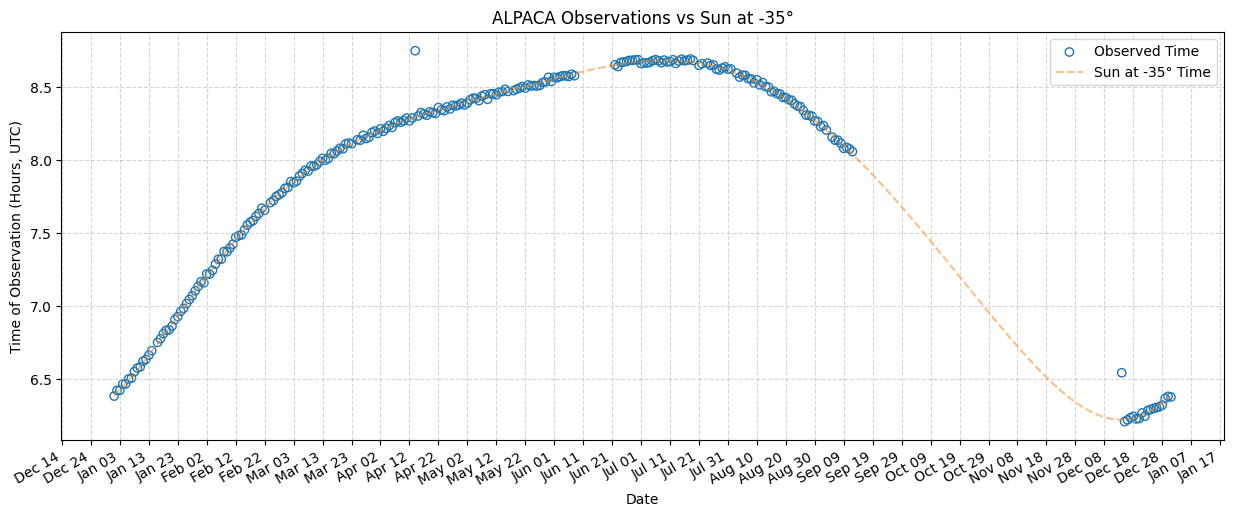

In [ ]:
times_obs = [time for time in results['date_obs']]
times_obs_mjd = Time(times_obs).mjd

fig, ax = plt.subplots(figsize=(15, 6))

# Convert times to datetime objects
dates =     [t.datetime.date() for t in Time(times_obs_mjd, format='mjd')]
obs_times = [t.datetime for t in Time(times_obs_mjd, format='mjd')]  # Full datetime
obs_hours = [t.hour + t.minute / 60 + t.second / 3600 for t in obs_times]  # Convert to fractional hours

# Convert Sun at -35° times
sun_dates = [t.datetime.date() for t in Time(times_mjd, format='mjd')]
sun_times = [t.datetime for t in Time(times, format='isot')]
sun_hours = [t.hour + t.minute / 60 + t.second / 3600 for t in sun_times]

# Scatter plot for observations
ax.scatter(dates, obs_hours, label="Observed Time", ec='C0', fc='none')

# Scatter plot for Sun at -35° times
# ax.scatter(sun_dates, sun_hours, label="Sun at -35° Time", color='C1', marker='x')
ax.plot(sun_dates, sun_hours, color='C1', ls='--', alpha=0.5, label="Sun at -35° Time")

# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format as "Month Day"
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Show ticks every 5 days
fig.autofmt_xdate()

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("Time of Observation (Hours, UTC)")
ax.set_title("ALPACA Observations vs Sun at -35°")
ax.legend()
ax.grid(ls='--', alpha=0.5)

plt.show()

In [87]:
data_files = eso.retrieve_data(results['dp_id'][:2], destination='./data/') # specify the destination directory for the download

INFO: Downloading datasets ... [astroquery.eso.core]
INFO: Downloading 2 files ... [astroquery.eso.core]
INFO: Downloading file 1/2 https://dataportal.eso.org/dataPortal/file/ALPACA.2024-01-01T06:23:08.420 to /Users/abarnes/GitHub/astroquery_examples/tests/tests_alpaca/data [astroquery.eso.core]
INFO: Found cached file /Users/abarnes/GitHub/astroquery_examples/tests/tests_alpaca/data/ALPACA.2024-01-01T06:23:08.420.fits [astroquery.eso.core]
INFO: Downloading file 2/2 https://dataportal.eso.org/dataPortal/file/ALPACA.2024-01-02T06:25:29.060 to /Users/abarnes/GitHub/astroquery_examples/tests/tests_alpaca/data [astroquery.eso.core]
INFO: Successfully downloaded dataset ALPACA.2024-01-02T06:25:29.060 to /Users/abarnes/GitHub/astroquery_examples/tests/tests_alpaca/data/ALPACA.2024-01-02T06:25:29.060.fits.Z [astroquery.eso.core]
INFO: Uncompressing file /Users/abarnes/GitHub/astroquery_examples/tests/tests_alpaca/data/ALPACA.2024-01-02T06:25:29.060.fits.Z [astroquery.eso.core]
INFO: Done! [a